In [2]:
# 라이브러리 로딩
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
# CIFAR10 이미지에 대한 명칭
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
# CIFAR10 학습 데이터 (training data) 로딩
from torchvision import datasets, transforms
data_path = './data/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),   # 이미지 --> 텐서 변환
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
# CIFAR10 검증 데이터 (validation data) 로딩
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
# 비행기와 새 이미지 데이터만 추출해서 레이블 0과 1로 재설정
label_map = {5: 0, 3: 1, 7:2}
class_names = ['dog', 'cat', 'horse']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [3, 5, 7]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [3, 5, 7]]

In [7]:
# convolution layer 생성 및 테스트 
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [8]:
# convolution layer weight과 bias 크기 점검
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
# convolution 입출력 테스트 
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

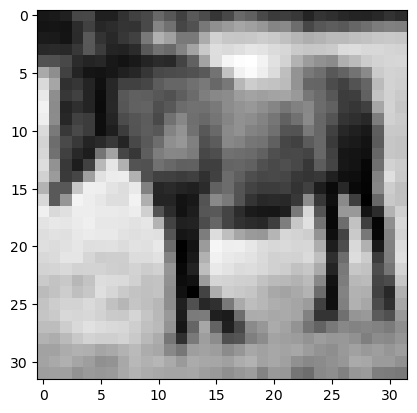

In [10]:
plt.imshow(img.mean(0), cmap='gray') # dim=0에 대해서 mean() 계산 수행
plt.show()

In [11]:
img, _ = cifar2[1]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

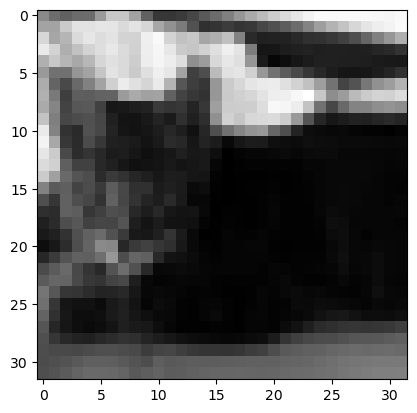

In [12]:
plt.imshow(img.mean(0), cmap='gray') 
plt.show()

In [13]:
img, _ = cifar2[2]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

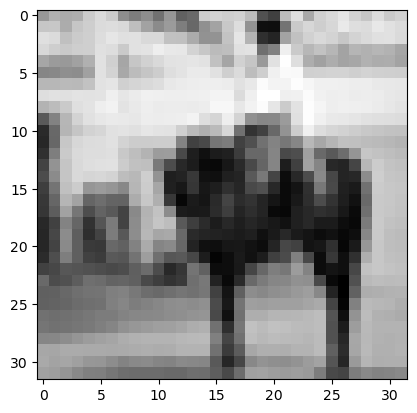

In [14]:
plt.imshow(img.mean(0), cmap='gray') 
plt.show()

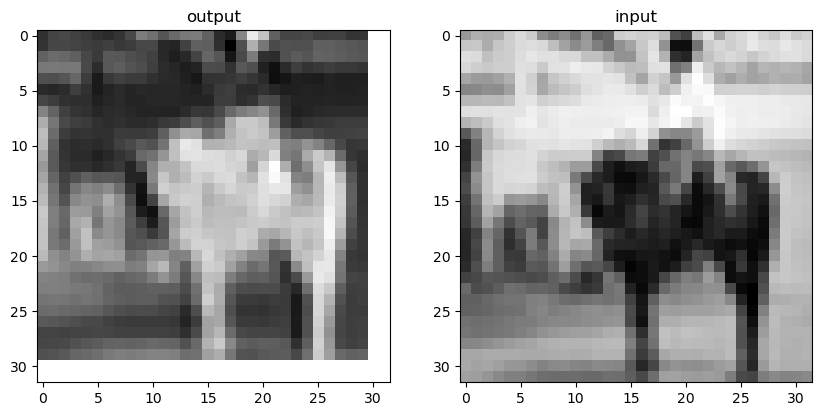

In [10]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [11]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [12]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0) # weight으로 1/9 초기화  

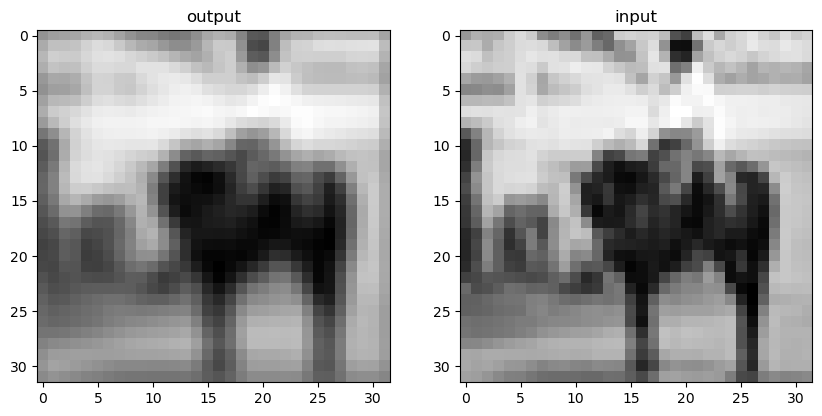

In [13]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [14]:
# vertical edge detection을 위한 필터값으로 세팅 
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

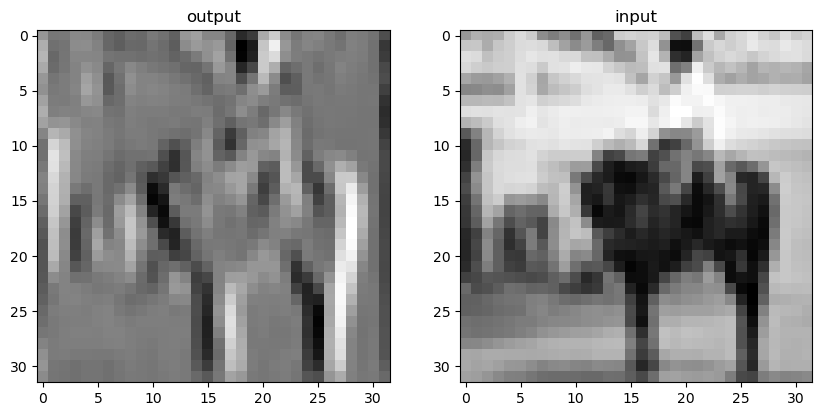

In [15]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [16]:
pool = nn.MaxPool2d(2) # kernel_size = 2 --> 2x2, stride = (default) kernel_size  
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [17]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [18]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 3))

In [19]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18123, [432, 16, 1152, 8, 16384, 32, 96, 3])

In [21]:
# 이전 모델로부터 에러의 이유는 8x8x8를 1차원벡터(512)로 변화시켜야한다. 하지만 Sequential 구문내에서는 그럴 방법이 없다. 
# nn.Module의 서브크래스로 우리만의 모델을 만들어야 함. 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # 1차원 벡터로 reshaping 
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [23]:
# 위의 모듈의 경우 __init__()에 등재된 모든 모듈에 대해서 패러미터가 있든 없든 추적--> 낭비. 
# 모듈과 동작하는 functional API를 사용하면 이 문제 해결. 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1119, -0.0305,  0.0653]], grad_fn=<AddmmBackward0>)

In [25]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [26]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-06-10 17:01:52.093129 Epoch 1, Training loss 1.0793568119089654
2024-06-10 17:10:12.975813 Epoch 10, Training loss 0.8021210581698316
2024-06-10 17:17:35.458707 Epoch 20, Training loss 0.6959164288449795
2024-06-10 17:25:53.040581 Epoch 30, Training loss 0.6296242237091064
2024-06-10 17:33:16.540420 Epoch 40, Training loss 0.5848053592316648
2024-06-10 17:39:45.626898 Epoch 50, Training loss 0.5472674320352838
2024-06-10 17:46:58.299794 Epoch 60, Training loss 0.5183419709509992
2024-06-10 17:56:07.320902 Epoch 70, Training loss 0.48997298593216754
2024-06-10 18:03:24.122775 Epoch 80, Training loss 0.46096967826498314
2024-06-10 18:11:20.124054 Epoch 90, Training loss 0.4330160960238031
2024-06-10 18:18:34.730570 Epoch 100, Training loss 0.40455725427637707


In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.83
Accuracy val: 0.73


In [28]:
# 모델의 모든 패러미터를 화일에 저장
torch.save(model.state_dict(), data_path + 'dogs_vs_cats_vs_horses.pt')

In [29]:
# 화일에 저장된 모델 패러미터를 읽어들임.
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'dogs_vs_cats_vs_horses.pt'))

<All keys matched successfully>